# Positional Encoding - Deep Dive

In [934]:
import torch 
import matplotlib.pyplot as plt

### absolute positional encoding

In [935]:
def plot_2d(token, pe, title=None, origin=(0,0)):
    
    c = ['b','g','r','c','m','y']*len(token)
    plt.figure(figsize=(6,6))
    
    for i, t in enumerate(token):        
        plt.quiver(*origin, *t, angles='xy', scale_units='xy', scale=1, color=c[i])
        plt.text(t[0] + 0.1, t[1] + 0.1, f"embedding {i} ({t[0].item():.2f}, {t[1].item():.2f})", fontsize=12, color=c[i])
    
    if pe is not None:
        token = token + pe
        for i, t in enumerate(token):        
            plt.quiver(*origin, *t, angles='xy', scale_units='xy', scale=1, color=c[i])
            plt.text(t[0] + 0.1, t[1] + 0.1, f"embedding + pe ({t[0].item():.2f}, {t[1].item():.2f})", fontsize=12, color=c[i])

        
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.axhline(0, color='black', linewidth=0.1)
    plt.axvline(0, color='black', linewidth=0.1)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.title(title)

    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_visible(False)

    plt.show()

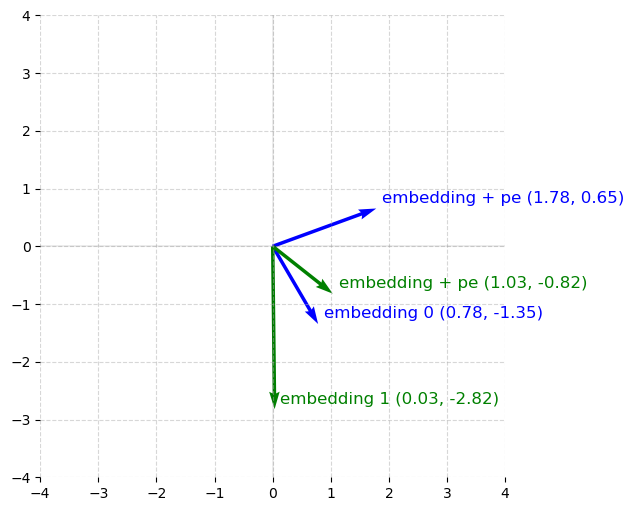

In [936]:
tokens = torch.randn(2, 2)
num_tokens = tokens.shape[1]
pe = torch.arange(1, num_tokens+1)
plot_2d(tokens, pe , title="")

### Sinosudal positional Encoding

In [190]:
from IPython.display import display, Math

display(Math(r"""
PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right), \quad 
PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)
"""))


<IPython.core.display.Math object>

In [937]:
d_model = 2
seq_len = 32
idx = torch.arange(0, d_model, 2)
n = 10000
dnom = 1/n**(idx/d_model)
pos = torch.arange(0, seq_len).unsqueeze(1)


In [938]:
pos.shape, dnom.shape

(torch.Size([32, 1]), torch.Size([1]))

In [939]:
tokens = torch.randn(seq_len, d_model)

In [940]:
pe = torch.zeros(seq_len, d_model)

pe[:,0::2] = torch.sin(pos*dnom)
pe[:,1::2] = torch.cos(pos*dnom)

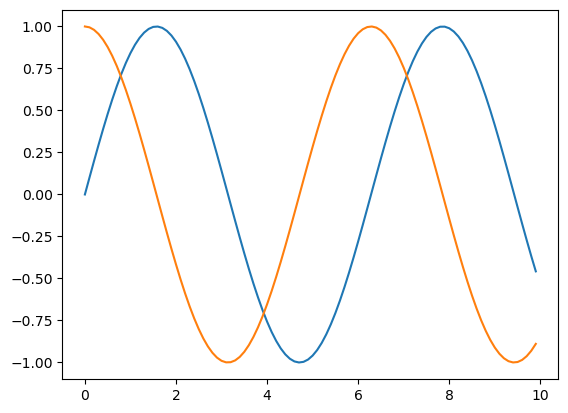

In [941]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(0, 10, 0.1)
y1 = np.sin(x)
y2 = np.cos(x)
fig, ax = plt.subplots()
ax.plot(x, y1)
ax.plot(x, y2)
plt.show()

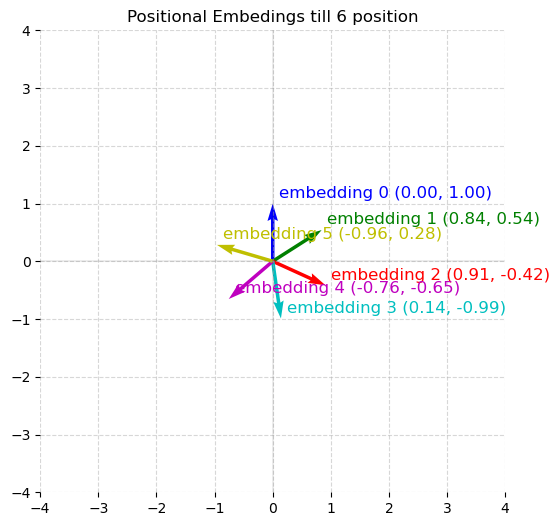

In [546]:
plot_2d(pe[:6], pe=None, title="Positional Embedings till 6 position")

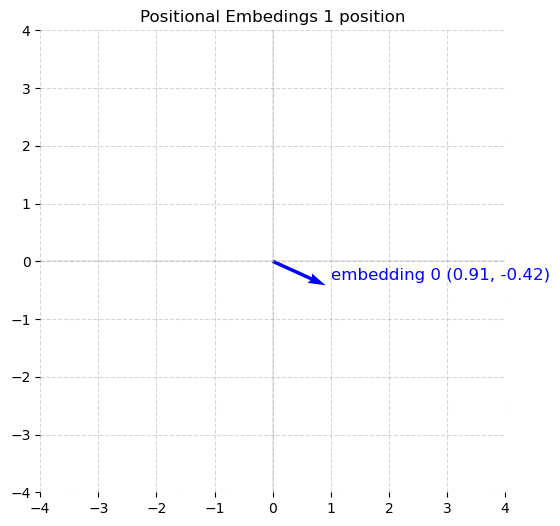

In [943]:

plot_2d(pe[2:3], pe=None, title="Positional Embedings 1 position")


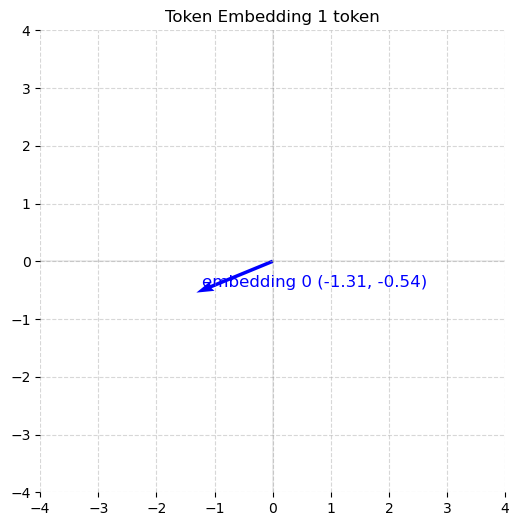

In [945]:
plot_2d(tokens[2:3] ,None , title="Token Embedding 1 token")

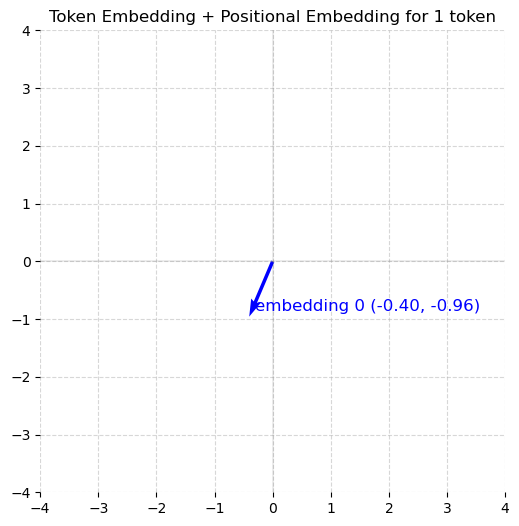

In [946]:
plot_2d(tokens[2:3] + pe[2:3]  ,None, title="Token Embedding + Positional Embedding for 1 token")

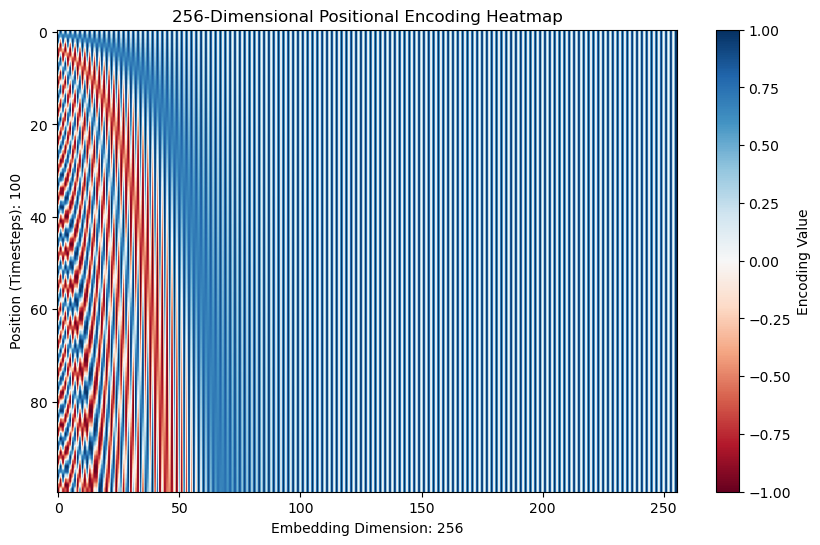

In [932]:
d_model = 256
seq_len = 100
idx = torch.arange(0, d_model, 2)
n = 10000

dnom = 1/n**((2*idx)/d_model)
pos = torch.arange(0, seq_len).unsqueeze(1)
tokens = torch.randn(seq_len, d_model)
pe = torch.zeros(seq_len, d_model)

pe[:,0::2] = torch.sin(pos*dnom)
pe[:,1::2] = torch.cos(pos*dnom)


plt.figure(figsize=(10, 6))
plt.imshow(pe.numpy(), cmap="RdBu", aspect="auto")
plt.colorbar(label="Encoding Value")
plt.xlabel(f"Embedding Dimension: {d_model}")
plt.ylabel(f"Position (Timesteps): {seq_len}")
plt.title(f"{d_model}-Dimensional Positional Encoding Heatmap")
# plt.show()
plt.savefig("SPE.png")

In [928]:
! ls /Users/nand/Documents/projects/ML_from_scratch/pytorch_practice

BN.ipynb       iframe_figures LN.ipynb       RoPE.ipynb     SPE.png


### ROPE

In [716]:
from IPython.display import display, Math

# RoPE formulas in LaTeX
display(Math(r"""
\textbf{Rotary Positional Embeddings (RoPE)} \\[6pt]
\text{Given a vector } x \in \mathbb{R}^d, \text{ split into pairs: } 
(x_{2i}, x_{2i+1}). \\[6pt]

\text{Apply rotation:} \quad
\begin{bmatrix}
x'_{2i} \\
x'_{2i+1}
\end{bmatrix}
=
\begin{bmatrix}
\cos\theta_m & -\sin\theta_m \\
\sin\theta_m & \cos\theta_m
\end{bmatrix}
\cdot
\begin{bmatrix}
x_{2i} \\
x_{2i+1}
\end{bmatrix}
\\[10pt]

\\

x'_{2i}  = cos\theta_m * x_{2i}  -\sin\theta_m *x_{2i+1}
 
\\
x'_{2i+1} = \sin\theta_m * x_{2i} + \cos\theta_m *x_{2i+1}
\\
\theta_m = \frac{m}{10000^{2i/d}} \quad \text{(position-dependent angle)}
"""))


<IPython.core.display.Math object>

In [1001]:
n = 10000
d_model = 2
seq_len = 1000

idx = torch.arange(0, d_model, 2)
dnom = n ** -(torch.arange(0, d_model, 2)/d_model)

m = torch.arange(0, seq_len).unsqueeze(1)
theta = m*dnom

In [1002]:
tokens = torch.rand((seq_len, d_model))
x_odd = tokens[:,1::2]
x_even = tokens[:,0::2]

In [1003]:
sin = torch.sin(theta)
cos = torch.cos(theta)

x_odd_rot = sin * x_even + cos * x_odd
x_even_rot = cos * x_even - sin * x_odd

In [1004]:
x_even_rot.shape, x_odd_rot.shape

(torch.Size([1000, 1]), torch.Size([1000, 1]))

In [1005]:
x = torch.stack([x_even_rot, x_odd_rot], dim=-1).reshape_as(tokens)

In [1006]:
def plot_2d_rope(token, title=None, origin=(0,0)):
    
    c = ['b','g','r','c','m','y']*len(token)
    # plt.figure(figsize=(2,2))
    
    for i, t in enumerate(token):        
        plt.quiver(*origin, *t, angles='xy', scale_units='xy', scale=1, color=c[i])
        plt.text(t[0] + 0.1, t[1] + 0.1, f"embedding {i} ({t[0].item():.2f}, {t[1].item():.2f})", fontsize=12, color=c[i])
    
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.axhline(0, color='black', linewidth=0.1)
    plt.axvline(0, color='black', linewidth=0.1)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.title(title)

    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_visible(False)

    plt.show()
    

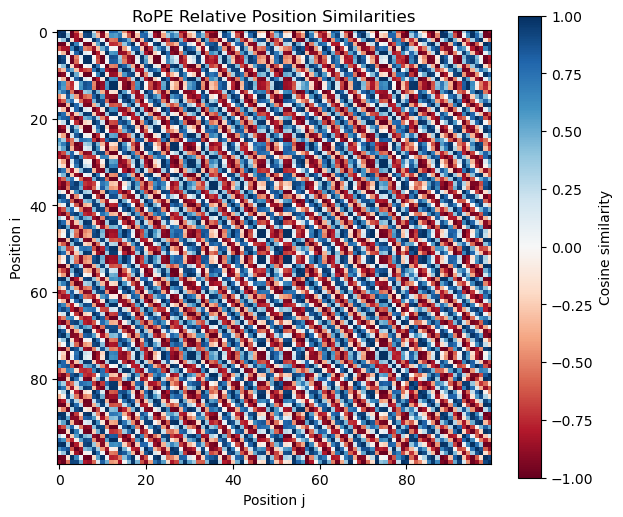

In [978]:
# Normalize to unit length for cosine similarity
x_norm = x / x.norm(dim=1, keepdim=True)

# Cosine similarity matrix
sim_matrix = x_norm @ x_norm.T

plt.figure(figsize=(7,6))
plt.imshow(sim_matrix.numpy(), cmap="RdBu", vmin=-1, vmax=1)
plt.colorbar(label="Cosine similarity")
plt.title("RoPE Relative Position Similarities")
plt.xlabel("Position j")
plt.ylabel("Position i")
plt.show()



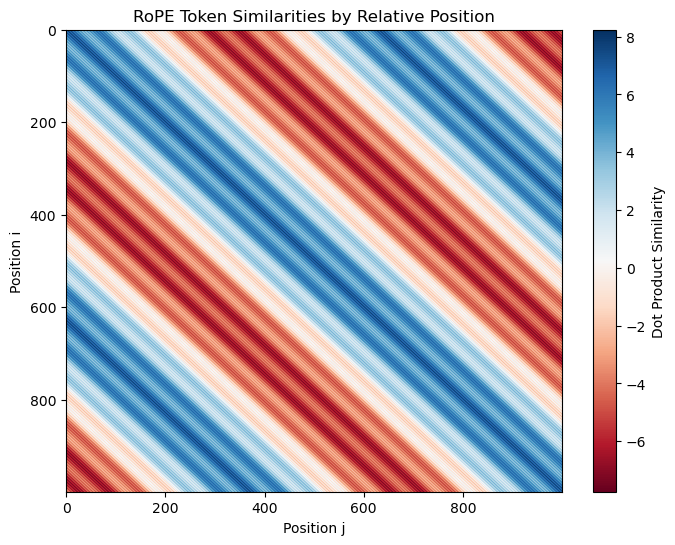

In [1012]:
import numpy as np
import matplotlib.pyplot as plt

def rope_encode(v, pos, d_model):
    """Apply RoPE rotation to vector v at position pos."""
    assert d_model % 2 == 0
    inv_freq = 1.0 / (10000 ** (np.arange(0, d_model, 2) / d_model))
    angles = pos * inv_freq
    sin, cos = np.sin(angles), np.cos(angles)
    v_even, v_odd = v[0::2], v[1::2]
    v_rot_even = v_even * cos - v_odd * sin
    v_rot_odd  = v_even * sin + v_odd * cos
    out = np.empty_like(v)
    out[0::2], out[1::2] = v_rot_even, v_rot_odd
    return out


d_model = 8
seq_len = 1000
rng = np.random.default_rng(42)
base = rng.standard_normal(d_model)

encodings = np.stack([rope_encode(base, pos, d_model) for pos in range(seq_len)])

#(dot products between positions)
sim_matrix = encodings @ encodings.T

plt.figure(figsize=(8, 6))
plt.imshow(sim_matrix, cmap="RdBu", aspect="auto")
plt.colorbar(label="Dot Product Similarity")
plt.title("RoPE Token Similarities by Relative Position")
plt.xlabel("Position j")
plt.ylabel("Position i")
# plt.show()
plt.savefig("Rope.png")
